In [1]:
# for importing data
import biom
import os
import qiime2
import numpy as np
import pandas as pd
from scipy import stats
from biom import Table
from gneiss.util import match
from skbio.stats.ordination import OrdinationResults
from scripts.helper import temporal_plot
from scripts.large_pickle import pickle_dump,pickle_load
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

# 1.1 Import pcoa results for each of the core-beta-diversity methods used.

In [2]:
# import data 
input_location = '../../data/DIABIMMUNE-Qiita-11884/'
mf = pd.read_csv(os.path.join(input_location,'11884_20190508-173103-added-month-abx.txt'),
                              sep='\t',index_col=0)
btdf = pd.read_csv(os.path.join(input_location, 'table-added-month-abx.txt'),
                   sep='\t',index_col=0)
csecmap = {False:'Vaginal', True:'Cesarean'}
mf['csection_labeled'] = [csecmap[x] for x in mf['csection']]
mf['Birth Mode:'] = mf['csection_labeled']

# get pcoa metric types
pcoa_name = {'Bray Curtis':'bray_curtis_pcoa_results.qza',
             'Jaccard':'jaccard_pcoa_results.qza',
             'UniFrac':'gUniFrac_alpha0_pcoa_results.qza',
             'W-UniFrac':'gUniFrac_alpha1_pcoa_results.qza',
             'Aitchison':'aitchison_pcoa_results.qza'}
# emoty dict to fill with tables
pcoa_tables = {}

#get r number PC-dims to store
r = 4
# where output is stored
output_path = '../../data/DIABIMMUNE-Qiita-11884/q2-analysis/core-metrics-results'
# for each metric and location import the pcoa table
for metric_name,file_name in pcoa_name.items():   
    file_name = os.path.join(output_path,file_name)
    # import OrdinationResults
    pc = qiime2.Artifact.load(file_name).view(OrdinationResults)
    # save r number pc axis 
    pcdf = pc.samples[list(range(r))]
    # also save explained variance
    eigs_ = np.array(sorted(pc.eigvals[list(range(r))].values)[::-1])
    prop_explained = eigs_**2 / np.sum(eigs_**2)
    # match metadata and pc-table along with prop. explained
    pcoa_tables[metric_name] = list(match(mf,pcdf)) + [prop_explained]

# import traj.
output_path = '../../data/DIABIMMUNE-Qiita-11884/q2-analysis/ctf-results'
CTF_ordination = qiime2.Artifact.load(os.path.join(output_path, 'subject_biplot.qza')).view(OrdinationResults)
subject_trajectory = qiime2.Artifact.load(os.path.join(output_path, 'state_subject_ordination.qza')).view(pd.DataFrame)
feature_trajectory = qiime2.Artifact.load(os.path.join(output_path, 'state_feature_ordination.qza')).view(pd.DataFrame)
# merge
subject_trajectory, pcdf = match(subject_trajectory,mf)
n_comp = 4
pcdf =  subject_trajectory[['PC'+str(i+1) for i in range(n_comp)]]
pcdf.columns = list(range(n_comp))
pcoa_tables['CTF'] = list(match(mf,pcdf)) + [CTF_ordination.proportion_explained.values]

# write mapping file to use for downstream
btdf_out = btdf.loc[:, mf.index]
mf.index.name = '#SampleID'
mf.to_csv(os.path.join(input_location,'metadata-matched.tsv'), sep='\t')
btdf_out.to_csv(os.path.join(input_location,'table-matched.tsv'), sep='\t')
with biom.util.biom_open(os.path.join(input_location,'table-matched.biom'), 'w') as f:
    Table(btdf_out.values, btdf_out.index, btdf_out.columns).to_hdf5(f, "DIABbinned")



# 1.2 Visualize the ordination along PC1

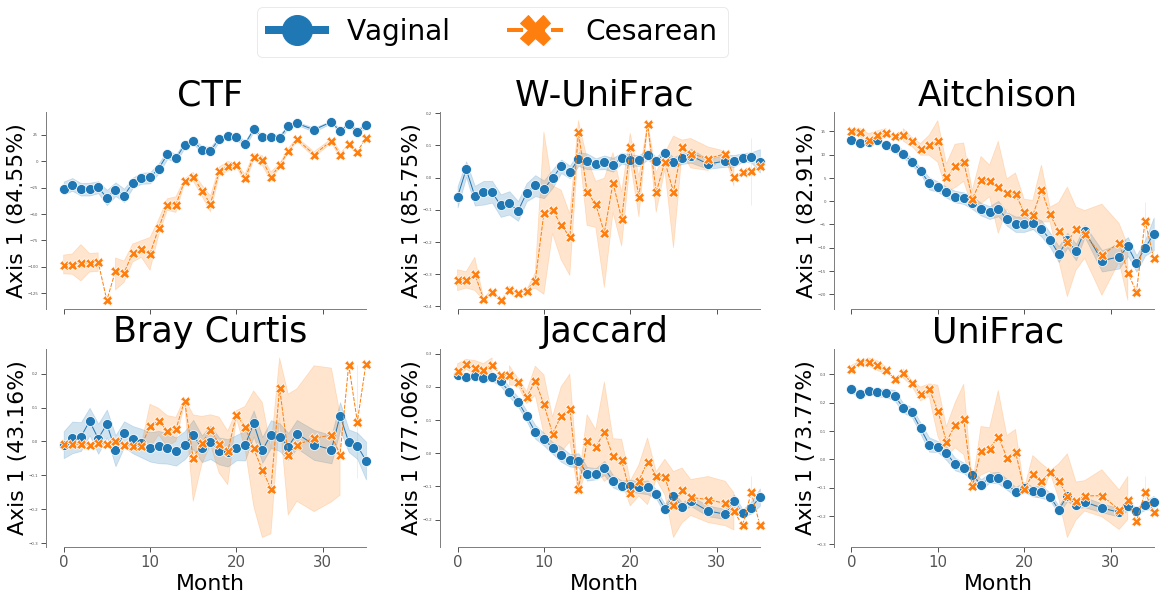

In [3]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 1, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 15 
plt.rcParams['ytick.labelsize'] = 4

i = 0 # iterator for axn
color_by = 'Birth Mode:' # colors for the plot
style_by = 'Birth Mode:' # markers for the plot

# figure perams
fig,axn = plt.subplots(2,3,figsize=(20,8),
                       sharex=True,
                       sharey=False)
# flatten the axis to easily iterate
axn = axn.flatten()
# for each row in figure
metrics_ = ['CTF', 'W-UniFrac', 'Aitchison',
            'Bray Curtis', 'Jaccard', 'UniFrac']
# for each metric saved -- in each column
for metric_name in metrics_:
    pcmf, pcdf, prop_expl = pcoa_tables[metric_name]
    # Add loadings to metadata for PC axis
    pc_i = 0
    pcmf['loading_tmp'] = pcdf[pc_i]
    # set title 
    if pc_i == 0:
        title = metric_name
        x_label = 'Month'
    else:
        title = ''
        x_label = ''
    # label y-label with % explained    
    y_label = 'Axis %i (%.2f%%)'%(pc_i+1, prop_expl[pc_i]*100)    
    # too few subjects here
    pcmf = pcmf[~pcmf.month.isin([28, 30])]
    axn[i] = temporal_plot('month','loading_tmp', pcmf, axn[i],
                           title, x_label, y_label, 35, 22, 22,
                           hue=color_by, style=style_by, ci=68)
    axn[i].set_xlim(-2,36)
    i += 1

# generate legend from last iterations     
handles, labels = axn[i-1].get_legend_handles_labels()
legend = axn[i-1].legend(handles[1:], labels[1:], loc=2, 
                         bbox_to_anchor=(-1.8, 2.8),
                         prop={'size':28},
                         fancybox=True, framealpha=0.5, 
                         ncol=2, markerscale=3, facecolor="white")
# increase the line width in the legend 
for line in legend.get_lines()[:-1]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[-1:]:
    line.set_linewidth(4.0)
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

# save the figure to file
plt.savefig('../../results/DIABIMMUNE-subjects-loadings.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()


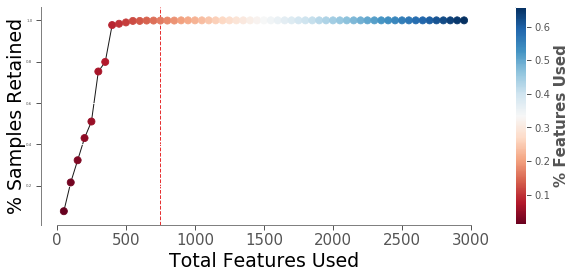

In [4]:
perc_kept = {}
btdfps = btdf.copy()
filt_ = btdfps.astype(bool).sum(1) / btdfps.shape[1] > .001
btdfps = btdfps[filt_]
for pi in np.arange(50, 3000, 50):
    pc = 'PC1'
    lr = []
    for month_,mdf  in feature_trajectory.groupby('month'):
        mdf = mdf.set_index('feature_id')
        mdf = mdf.sort_values(pc)
        subids = mf[mf.month.isin([int(month_)])].index
        num_ind = mdf['PC1'][:pi].index
        den_ind = mdf['PC1'][-pi:].index
        num = np.log(btdfps.loc[num_ind,subids].sum(axis=0))
        den = np.log(btdfps.loc[den_ind,subids].sum(axis=0))
        lr_sub = pd.DataFrame(num - den,columns=['logratio'])
        lr_sub['month'] = month_
        lr.append(lr_sub)
    lr = pd.concat(lr)
    #label csection
    csection_map = {k1:v for k1,v in zip(mf.subjectid,
                                         mf.csection)}
    idmap = {ind.split('.')[-1]:id_ for ind,id_ in zip(mf.index,
                                                       mf.subjectid)}
    lr['csection'] = [csecmap[csection_map[idmap[ind.split('.')[-1]]]]
                      for ind in lr.index]
    lr['subject_id'] = [idmap[ind.split('.')[-1]] for ind in lr.index]
    lr_ = lr['logratio']
    lr_[~np.isfinite(lr_)] = np.nan
    lr['logratio'] = lr_
    lr = lr.dropna(subset=['logratio'])
    perc_kept[pi] = [lr.shape[0] / btdfps.shape[1],
                     pi / btdfps.shape[0]]
lr_Ndf = pd.DataFrame(perc_kept, ['percent-sample',
                                  'percent-features']).T

fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.plot(lr_Ndf.index, lr_Ndf['percent-sample'],
        alpha=.9, c='black', zorder=-1)
points = ax.scatter(lr_Ndf.index,
                    lr_Ndf["percent-sample"],
                    c=lr_Ndf["percent-features"],
                    s=50, cmap="RdBu")
cbar = fig.colorbar(points)
cbar.set_label(label='% Features Used',
               size=15,weight='bold')
cbar.ax.tick_params(labelsize=10) 
ax.axvline(750, c='#e41a1c', ls='--',
           alpha=.9, zorder=-1)

ax.set_xlabel('Total Features Used', color='#000000',
              fontsize=19)
ax.set_ylabel('% Samples Retained', color='#000000',
              fontsize=19, labelpad=0)

# remove all grids, backrounds etc ...
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_bounds(0, 3000)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

# save the figure to file
plt.savefig('../../results/DIABIMMUNE-lr-N-plot.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

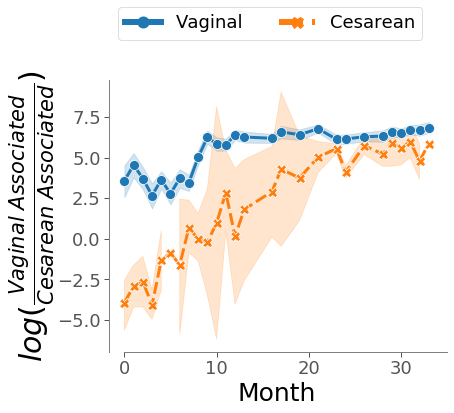

In [40]:
pc = 'PC1'
lr = []
pi = 375
btdfps = btdf.copy()
btdfps = btdf.copy()
filt_ = btdfps.astype(bool).sum(1) / btdfps.shape[1] > .001
btdfps = btdfps[filt_]
for month_,mdf  in feature_trajectory.groupby('month'):
    mdf = mdf.set_index('feature_id')
    mdf = mdf.sort_values(pc)
    subids = mf[mf.month.isin([int(month_)])].index
    num_ind = mdf['PC1'][:pi].index
    den_ind = mdf['PC1'][-pi:].index
    num = np.log(btdfps.loc[num_ind,subids].sum(axis=0))
    den = np.log(btdfps.loc[den_ind,subids].sum(axis=0))
    lr_sub = pd.DataFrame(num - den,columns=['logratio'])
    lr_sub['month'] = month_
    lr.append(lr_sub)
lr = pd.concat(lr)
#label csection
csection_map = {k1:v for k1,v in zip(mf.subjectid,
                                     mf.csection)}
idmap = {ind.split('.')[-1]:id_ for ind,id_ in zip(mf.index,
                                                   mf.subjectid)}
lr['csection'] = [csecmap[csection_map[idmap[ind.split('.')[-1]]]]
                  for ind in lr.index]
lr['subject_id'] = [idmap[ind.split('.')[-1]] for ind in lr.index]
lr_ = lr['logratio']
lr_[~np.isfinite(lr_)] = np.nan
lr['logratio'] = lr_
lr = lr.dropna(subset=['logratio'])

lr = pd.concat([lr, mf.reindex(lr.index)[['abx_ever','subjectid']]],axis=1)
diet_ = {}
for s_, sdf_ in mf.groupby('subjectid'): 
    if sdf_['breastfeeding_length_exclusive'].min() != 'not provided'\
       and int(sdf_['breastfeeding_length_exclusive'].min()) > 0:
        diet_[s_] = 'bd'
    else:
        diet_[s_] = 'fd'

lr['diet'] = [diet_[sid] for sid in lr.subjectid]

# set label font-sizes globally
paper_rc = {'lines.linewidth': 3, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 18

fig,ax = plt.subplots(1,1,figsize=(6,5))

# plot labels
y_label = '$log(\\frac{Vaginal\,\,Associated}{Cesarean\,\,Associated})$'
x_label = 'Month' 
title = ''
# generate plot
# too few subjects drop out from zeros
lr = lr[~lr.month.isin([14, 15, 18, 20, 22,
                        25, 27, 34 , 35])]
ax = temporal_plot('month','logratio', lr, ax,
                    title, x_label, y_label, 35, 25, 30,
                    hue='csection', style="csection", ci=68)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], labels[1:],
            prop={'size':18}, loc=2, 
            bbox_to_anchor=(0.00, 1.3),
            fancybox=True, framealpha=0.8,ncol=2
            , markerscale=1.1, facecolor="white")

# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(6.0)

# save the figure to file
plt.savefig('../../results/DIABIMMUNE-log-ratio.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()


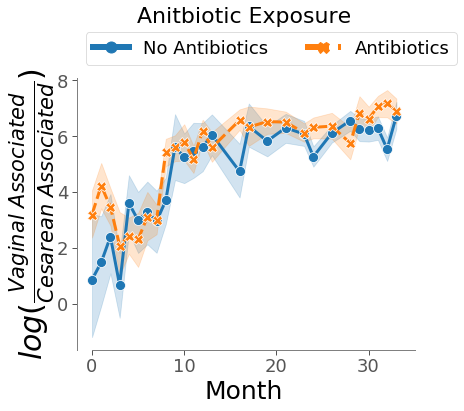

In [48]:

# set label font-sizes globally
paper_rc = {'lines.linewidth': 3, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 18

fig,ax = plt.subplots(1,1,figsize=(6,5))

# plot labels
y_label = '$log(\\frac{Vaginal\,\,Associated}{Cesarean\,\,Associated})$'
x_label = 'Month' 
title = ''
# generate plot
# too few subjects drop out from zeros
lr = lr[~lr.month.isin([14, 15, 18, 20, 22,
                        25, 27, 34 , 35])]
ax = temporal_plot('month','logratio', lr, ax,
                    title, x_label, y_label, 35, 25, 30,
                    hue='abx_ever', style="abx_ever", ci=68)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], labels[1:],
            prop={'size':18}, loc=2, 
            bbox_to_anchor=(0.00, 1.2),
            fancybox=True, framealpha=0.8,ncol=2
            , markerscale=1.1, facecolor="white")

# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(6.0)
ax.set_title('Anitbiotic Exposure', fontsize=22, y=1.18)

# save the figure to file
plt.savefig('../../results/DIABIMMUNE-log-ratio-abx.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

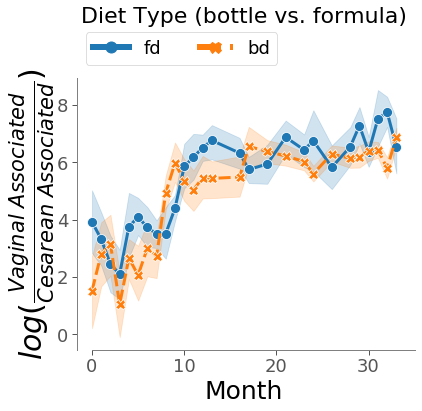

In [47]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 3, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 18

fig,ax = plt.subplots(1,1,figsize=(6,5))

# plot labels
y_label = '$log(\\frac{Vaginal\,\,Associated}{Cesarean\,\,Associated})$'
x_label = 'Month' 
title = ''
# generate plot
# too few subjects drop out from zeros
lr = lr[~lr.month.isin([14, 15, 18, 20, 22,
                        25, 27, 34 , 35])]
ax = temporal_plot('month','logratio', lr, ax,
                    title, x_label, y_label, 35, 25, 30,
                    hue='diet', style="diet", ci=68)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], labels[1:],
            prop={'size':18}, loc=2, 
            bbox_to_anchor=(0.00, 1.2),
            fancybox=True, framealpha=0.8,ncol=2
            , markerscale=1.1, facecolor="white")
ax.set_title('Diet Type (bottle vs. formula)', fontsize=22, y=1.18)

# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(6.0)

# save the figure to file
plt.savefig('../../results/DIABIMMUNE-log-ratio-diet.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

In [29]:
lrq2 = lr.rename({'Birth Mode:':'csection',
                  'Antibiotics:':'abx_ever',
                  'log-ratio':'logratio'},axis=1)
qiime2.Metadata(lrq2).save('../../data/DIABIMMUNE-Qiita-11884/q2-analysis/ctf-results/log-ratio.tsv')
lrq2.to_csv('../../data/DIABIMMUNE-Qiita-11884/q2-analysis/ctf-results/log-ratio.csv')


In [30]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

le.fit(lrq2.csection)
lrq2['bmode'] = le.transform(lrq2.csection)

le.fit(lrq2.subjectid)
lrq2['hsid'] = le.transform(lrq2.subjectid)


md = smf.mixedlm("logratio ~ bmode * month", lrq2, groups=lrq2["hsid"])
mdf = md.fit()
print(mdf.summary())

         Mixed Linear Model Regression Results


Model:            MixedLM Dependent Variable: logratio  

No. Observations: 730     Method:             REML      

No. Groups:       40      Scale:              5.2100    

Min. group size:  10      Likelihood:         -1682.1624

Max. group size:  27      Converged:          Yes       

Mean group size:  18.2                                  

--------------------------------------------------------

              Coef.  Std.Err.   z    P>|z| [0.025 0.975]

--------------------------------------------------------

Intercept     -2.491    0.785 -3.173 0.002 -4.030 -0.952

bmode          6.362    0.832  7.644 0.000  4.731  7.993

month          0.306    0.023 13.306 0.000  0.261  0.351

bmode:month   -0.204    0.025 -8.259 0.000 -0.252 -0.156

Group Var      1.791    0.215                           





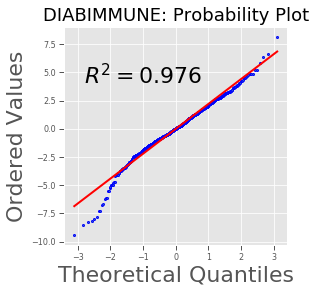

In [31]:
import scipy as sp
             
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 8 
plt.rcParams['ytick.labelsize'] = 8

fig, ax = plt.subplots(figsize=(4,4))
_, (__, ___, r) = sp.stats.probplot(mdf.resid, plot=ax, fit=True)
ax.annotate('$R^{2}=%.3f$'%r**2, (-2.8,4),fontsize=22)

ax.get_lines()[0].set_marker('o')
ax.get_lines()[0].set_markerfacecolor('#377eb8')
ax.get_lines()[0].set_markersize(2.0)
ax.get_lines()[1].set_linewidth(2.0)

ax.set_title('DIABIMMUNE: Probability Plot',fontsize=18)
ax.set_ylabel('Ordered Values',fontsize=22)
ax.set_xlabel('Theoretical Quantiles',fontsize=22)

plt.savefig('../../results/DIABIMMUNE-lme-resid.pdf',dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

In [32]:
mdf.summary().tables[1].to_csv('../../results/DIABIMMUNE-log-ratio-lme-stats.tsv')
mdf.summary().tables[1]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-2.491,0.785,-3.173,0.002,-4.030,-0.952
bmode,6.362,0.832,7.644,0.000,4.731,7.993
month,0.306,0.023,13.306,0.000,0.261,0.351
bmode:month,-0.204,0.025,-8.259,0.000,-0.252,-0.156
Group Var,1.791,0.215,,,,
